In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import SGD
from sklearn import svm
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)




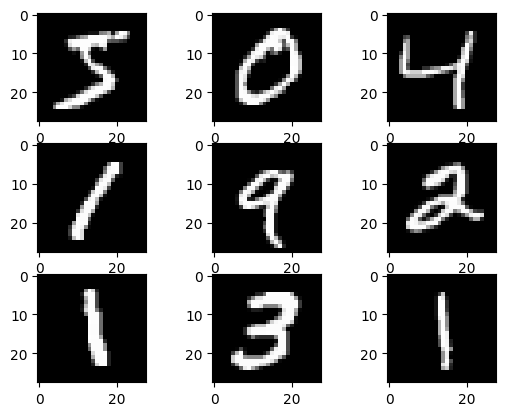

In [2]:
# -------------------------------------------
# LOAD DATASET
# -------------------------------------------
(trainX, trainy),(testX,testy) = mnist.load_data()
print("Train: X={}, y={}".format(trainX.shape,trainy.shape))
print("Test: X={}, y={}".format(testX.shape,testy.shape))
print("\n")

# plot first few images
for i in range(9):
  plt.subplot(330+1+i)
  plt.imshow(trainX[i],cmap=plt.get_cmap('gray'))
plt.show()

In [3]:
# LOAD & TEST DATASETS

# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
# one hot encode target values
trainy = to_categorical(trainy)
testy = to_categorical(testy)

In [4]:

# -------------------------------------------
# PREPARE PIXEL DATA
# -------------------------------------------

# Convert from int to float
trainX = trainX.astype('float32')
testX = testX.astype('float32')

# normalize to range [0-1]
trainX = trainX / 255.0
testX = testX / 255.0

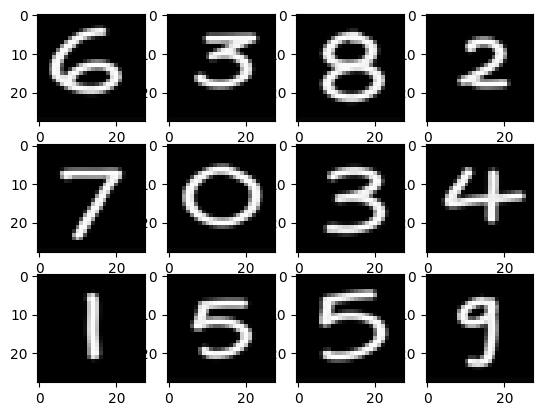

In [5]:
# -------------------------------------------
#  OWN TEST CASE
# -------------------------------------------

# for extra or self made test case please add .png files in your current directory
from PIL import Image

filenames = []
for file in os.listdir("."):
  if file.endswith(".png"):
    filenames.append(file)

if os.path.exists(filenames[0]):
  predicted_data = []
  target_size = (28, 28)
  for f in filenames:
    img = Image.open(f).convert("L")     # grayscale (1 channel)
    img = img.resize(target_size)        # resize to 28x28
    img_array = np.array(img)
    predicted_data.append(img_array)
  for i in range(len(filenames)):
    plt.subplot(3,4,i+1)
    plt.imshow(predicted_data[i],cmap=plt.get_cmap('gray'))
  plt.show()
  X_predicted = np.stack(predicted_data, axis=0).astype("float32") / 255.0

else:
  X_predicted = None
  predicted_data = None

In [6]:
# -------------------------------------------
#  SVM : SUPPORT VECTOR MACHINE
# -------------------------------------------

# define svm model
from sklearn import svm
from sklearn.metrics import accuracy_score

def define_model_svm():
    return svm.SVC(kernel="linear")   # can change kernel to 'rbf'


In [7]:
# -------------------------------------------
#  CNN : CONVOLUSIONAL NEURAL NETWORK
# -------------------------------------------

# define cnn model
def define_model_cnn():
  model = Sequential()
  model.add(Conv2D(32,(3,3),activation='relu',kernel_initializer='he_uniform',input_shape=(28,28,1)))
  model.add(MaxPooling2D((2,2)))
  model.add(Flatten())
  model.add(Dense(100,activation='relu',kernel_initializer='he_uniform'))
  model.add(Dense(10,activation='softmax'))

  # Compile model
  opt = SGD(learning_rate=0.01,momentum=0.9)
  model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [8]:
# -------------------------------------------
#  DNN : DEEP NEURAL NETWORK
# -------------------------------------------

# define dnn model
def define_model_dnn():
  model = Sequential()
  model.add(Flatten(input_shape=(28,28,1)))
  model.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(256,activation='relu',kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(10,activation='softmax'))
  # Compile model
  # opt = SGD(learning_rate=0.01,momentum=0.9)
  model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [9]:
# -------------------------------------------
#  EVALUATE MODEL
# -------------------------------------------
def evaluate_model(dataX, dataY, define_model,
                   isCNN=False, isSVM=False, n_folds=5):
    scores, histories,trained_models = list(), list(), list()
    kfold = KFold(n_folds, shuffle=True, random_state=1)

    for train_ix, test_ix in kfold.split(dataX):
        model = define_model()

        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

        if isSVM:
            # Flatten data for SVM
            trainX = trainX.reshape(trainX.shape[0], -1)
            testX = testX.reshape(testX.shape[0], -1)

            # Ensure labels are integers
            if len(trainY.shape) > 1:
                trainY = np.argmax(trainY, axis=1)
                testY = np.argmax(testY, axis=1)

            # Train and evaluate
            model.fit(trainX, trainY)
            y_pred = model.predict(testX)
            acc = accuracy_score(testY, y_pred)
            history = None

        else:
            # CNN / DNN training
            history = model.fit(trainX, trainY,
                                epochs=10, batch_size=64,
                                validation_data=(testX, testY),
                                verbose=0)
            _, acc = model.evaluate(testX, testY, verbose=0)

        print('> %.3f' % (acc * 100.0))
        scores.append(acc)
        histories.append(history)
        trained_models.append(model)

    return scores, histories , trained_models


In [10]:
# -------------------------------------------
#  CUSTOM TEST CASE PREDICTION
# -------------------------------------------

def predict_custom(model, X_predicted,predicted_data, isCNN=False, isSVM=False):
     # ---- Predict custom test case ----
  if X_predicted is not None and predicted_data is not None:
      if isSVM:
          X_input = X_predicted.reshape(X_predicted.shape[0], -1)
          custom_pred = model.predict(X_input)
      elif isCNN:
          X_input = X_predicted.reshape(X_predicted.shape[0], 28, 28, 1)
          custom_pred = np.argmax(model.predict(X_input), axis=1)
      else:
          X_input = X_predicted.reshape(X_predicted.shape[0], 28, 28)
          custom_pred = np.argmax(model.predict(X_input), axis=1)

      for i in range(len(predicted_data)):
          plt.subplot(3,4,i+1)
          plt.imshow(predicted_data[i],cmap=plt.get_cmap('gray'))
          plt.title("Prediction: " + str(custom_pred[i]))
          plt.axis("off")
      plt.show()

In [11]:
# -------------------------------------------
#  PLOT DIAGONISTICS LEARNING CURVE
# -------------------------------------------

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

In [12]:
# -------------------------------------------
# SUMMARISE MODEL PERFORMANCE
# -------------------------------------------

def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


> 98.317
> 98.333
> 98.475
> 98.625
> 98.492


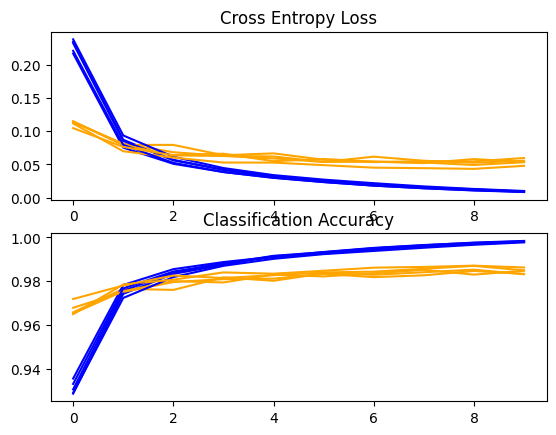

Accuracy: mean=98.448 std=0.113, n=5


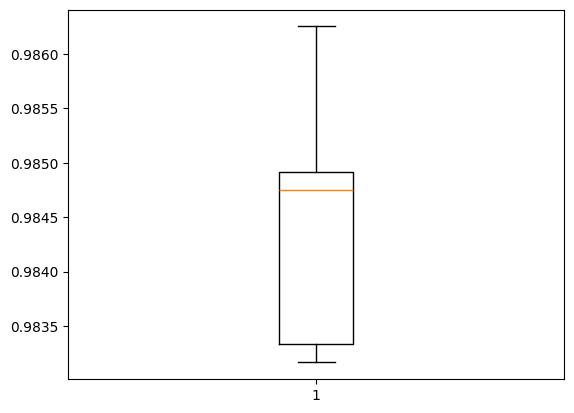

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


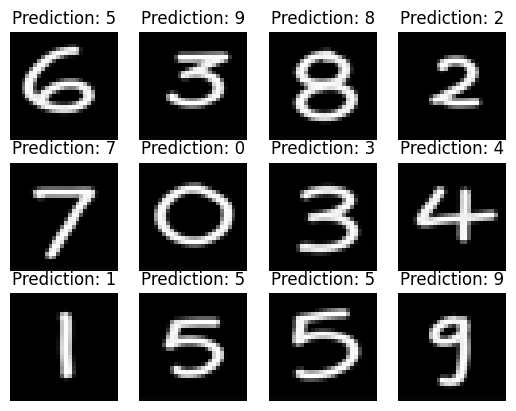

In [13]:
# -------------------------------------------
# RUN THE TEST CNN
# -------------------------------------------
scores_cnn, histories_cnn, models_cnn = evaluate_model(trainX,
                                  trainy,
                                  define_model_cnn,
                                  isCNN=True)
# Pick the best model (e.g., last one or the one with highest acc)
best_model_cnn = models_cnn[-1]
summarize_diagnostics(histories_cnn)
summarize_performance(scores_cnn)
predict_custom(best_model_cnn, X_predicted,predicted_data, isCNN=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


> 97.767
> 98.017
> 98.000
> 98.317
> 98.092


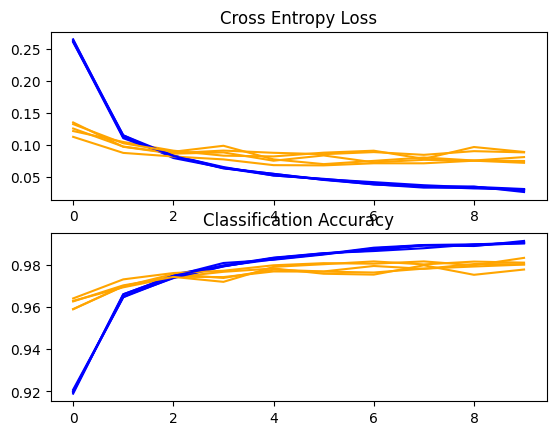

Accuracy: mean=98.038 std=0.177, n=5


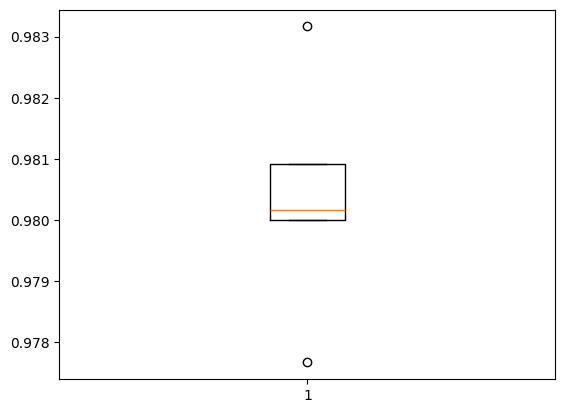

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


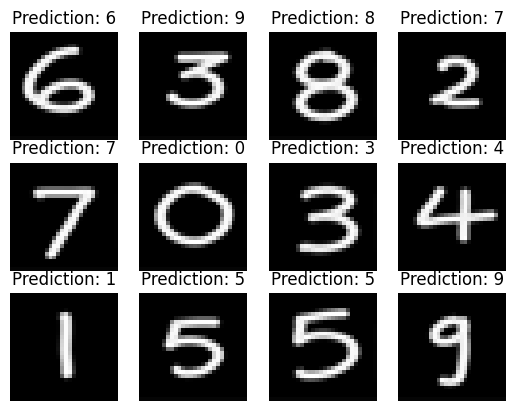

In [14]:
# -------------------------------------------
# RUN THE TEST FOR DNN
# -------------------------------------------

scores_dnn, histories__dnn, models_dnn = evaluate_model(trainX,
                                  trainy,
                                  define_model_dnn,
                                  isCNN=False)
# Pick the best model (e.g., last one or the one with highest acc)
best_model_dnn = models_dnn[-1]
summarize_diagnostics(histories__dnn)
summarize_performance(scores_dnn)
predict_custom(best_model_dnn, X_predicted,predicted_data, isCNN=False)

> 93.458
> 93.308
> 93.200
> 93.600
> 93.483
Accuracy: mean=93.410 std=0.140, n=5


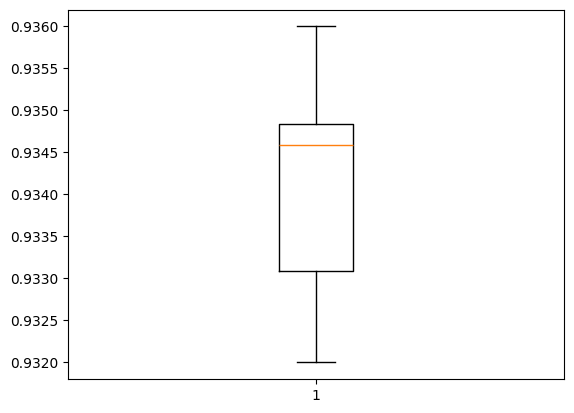

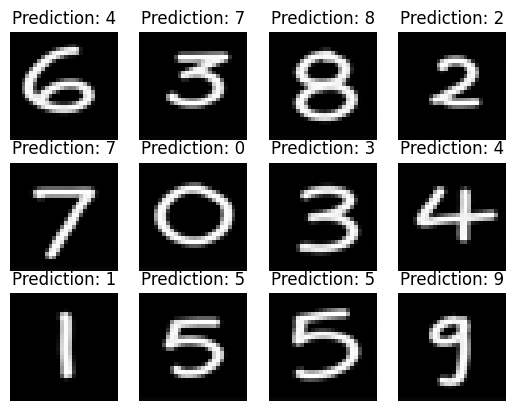

In [15]:
# -------------------------------------------
# RUN THE TEST FOR SVM
# -------------------------------------------

scores_svm, histories_svm, models_svm = evaluate_model(trainX,
                                   trainy,
                                   define_model_svm,
                                   isCNN=False,
                                   isSVM=True)
# Pick the best model (e.g., last one or the one with highest acc)
best_model_svm = models_svm[-1]
summarize_performance(scores_svm)
predict_custom(best_model_svm, X_predicted,predicted_data, isCNN=False, isSVM=True)
